# Set-up

## Package management

In [1]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import preprocessing, manifold
import scipy.sparse as sp
from scipy import linalg

# --- Network science ---
from cdlib import algorithms
import networkx as nx

# --- Data handling and visualization ---
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

import seaborn as sns

# --- Miscelleaneous ---
from tqdm.auto import tqdm

# --- Project source code ---
sys.path.append("../../../")
sys.path.append("../../../src/")

from src.hypercomparison import networks as hypnet

# Data
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import lfr_multiplex  # benchmark samplers

# Sampling
from src.sampling.random import partial_information  # PFI observation

# Classifiers
from src.classifiers.features import *  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'leidenalg', 'wurlitzer', 'infomap', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


# Global Config

In [2]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"


In [3]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

# Data set-up

In [4]:
# --- Data/Experiment Configurations ---
class NetworkParams(Enum):
    # Shared params
    N = 200
    PROB = 1.0
    T1 = 2.1
    KMAX = np.sqrt(200)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    KAVG = 5.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 11, endpoint=True)

LOGREG = {
    "fit_intercept": True,  # include intercept accounting for class imbalance
    "solver": "newton-cholesky",  # uses Cholesky-decomposition to approximate Hessian for Newton-esque method
    "penalty": None  # do not include coefficient regularization
}

## Function set-up

In [5]:
"""
Implementations of Isomap
Metric MDS + shortest path length matrix of a network
"""
class MDSBase:
    def __init__(self, dimension):
        self.dimension = dimension

    def train(self, network):
        self.network = network
        self.network.generate_shortest_path_length_matrix()
        self.embeddings_matrix = self._get_embedding()

        if len(self.embeddings_matrix) == 0:
            self.embeddings = {}
        else:
            self.embeddings = {
                self.network.id2node[i]: self.embeddings_matrix[i] for i in range(len(self.network.id2node))
            }
        return self.embeddings


class Isomap(MDSBase):
    def __init__(self, dimension=2):
        super(Isomap, self).__init__(dimension)

    def _get_embedding(self):
        return manifold.MDS(
            self.dimension, dissimilarity="precomputed").fit_transform(
                self.network.shortest_path_length_matrix)

In [6]:
def get_network(
        N=int(NetworkParams.N.value),  # number of nodes
        T1=NetworkParams.T1.value,  # degree distribution exponent
        T2=NetworkParams.T2.value,  # community size distribution exponent
        MU=NetworkParams.MU.value,  # community mixing parameter
        KAVG=NetworkParams.KAVG.value,  # average degree
        KMAX=NetworkParams.KMAX.value,  # maximum degree
        MIN_COMMUNITY=NetworkParams.MIN_COMMUNITY.value,  # minimum community size (ignored)
        PROB=NetworkParams.PROB.value,  # degree sequence correlation,
        ROOT="../../"):
    duplex, _, _, _ = lfr_multiplex(N, T1, T2, MU, KAVG, KMAX, MIN_COMMUNITY, PROB, ROOT)
    duplex = duplex_network(duplex, 1, 2, verbose=True)

    return duplex

In [7]:
def get_remnants(theta, G, H):
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }

    return record

In [8]:
def embed_remnants_Isomap(
        remnants_record,
        params,
        normalize=True,
        nodelist=None):
    g, h = remnants_record["remnants"]
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]

    G_ = hypnet.NetworkBase()
    G_.G = g
    H_ = hypnet.NetworkBase()
    H_.G = h

    embeddings_G = Isomap(dimension=params["dimension"]).train(G_)
    embeddings_H = Isomap(dimension=params["dimension"]).train(H_)

    distances_G_train, distances_H_train = get_distances((embeddings_G, embeddings_H), E_train)
    distances_G_test, distances_H_test = get_distances((embeddings_G, embeddings_H), E_test)

    # * >>> Match FR notebook >>>
    # distances_G_train = [x**2 for x in distances_G_train]
    # distances_H_train = [x**2 for x in distances_H_train]
    # distances_G_test = [x**2 for x in distances_G_test]
    # distances_H_test = [x**2 for x in distances_H_test]
    # * <<< Match FR notebook <<<

    feature_distances_train = get_configuration_distances_feature(distances_G_train, distances_H_train, zde_penalty=0.1)
    feature_distances_test = get_configuration_distances_feature(distances_G_test, distances_H_test, zde_penalty=0.1)

    if normalize:
        normalizer = max(np.abs(feature_distances_train))
        feature_distances_train = list(map(lambda x: x / normalizer, feature_distances_train))

        normalizer = max(np.abs(feature_distances_test))
        feature_distances_test = list(map(lambda x: x / normalizer, feature_distances_test))

    return feature_distances_train, feature_distances_test

In [9]:
def get_degree_features(remnants_record):
    G, H = remnants_record["remnants"]
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]
    # Partially compute degree likelihood feature
    src_degrees_train, tgt_degrees_train = get_degrees((G, H), E_train)
    src_degrees_test, tgt_degrees_test = get_degrees((G, H), E_test)

    # Complete degree likelihood feature calculations
    feature_degrees_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
    feature_degrees_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

    return feature_degrees_train, feature_degrees_test

In [10]:
def train_test_model(remnants_record, distances, degrees):
    E_train = remnants_record["observed_edges"]
    E_test = remnants_record["unobserved_edges"]

    # Retrieve data labels
    Y_train, Y_test = get_labels(E_train, E_test)

    # Unpack training features
    dist_train, dist_test = distances
    degs_train, degs_test = degrees
    X_train, X_test = format_feature_matrix(
        {"emb", "imb", "deg"},
        len(E_train), len(E_test),
        dist_train, dist_test,
        degs_train, degs_test
    )

    # Train model
    model = train_fit_logreg(X_train, Y_train, LOGREG)

    # Evaluate model
    accuracy = get_model_accuracy(model, X_test, Y_test)
    auroc = get_model_auroc(model, X_test, Y_test)
    aupr = get_model_aupr(model, X_test, Y_test)

    # Pack output
    output = {
        "model": model,
        "intercept": model.intercept_[0],
        "coefs": model.coef_[0],
        "accuracy": accuracy,
        "auroc": auroc,
        "aupr": aupr,
    }

    return output

In [11]:
def analysis(G, H):
    df = dict()

    params = {"dimension": 128, "beta": 0.1}
    nodelist = sorted(G.nodes())

    for theta in tqdm(ExperimentParams.THETAS.value, desc="Sweeping theta..."):
        remnants_record = get_remnants(theta, G, H)
        degrees = get_degree_features(remnants_record)
        distances = embed_remnants_Isomap(remnants_record, params, nodelist=nodelist)

        # ! NaN hotfix
        try:
            df[theta] = train_test_model(remnants_record, distances, degrees)
        except ValueError:
            continue
        except Exception as err:
            raise err


    return df

# Experiments

In [12]:
results = dict()  # t2 -> results
LOGREG["solver"] = 'newton-cg'
LOGREG["penalty"] = 'none'

for T1 in [2.1, 2.5, 2.9, 3.5]:
    print(f"\n\n--- T1 = {T1} ---\n")
    G, H = get_network(T1=T1, ROOT="../../../")
    results[T1] = analysis(G, H)



--- T1 = 2.1 ---

Number of common edges removed: 18
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 400


Sweeping theta...:   0%|          | 0/11 [00:00<?, ?it/s]



--- T1 = 2.5 ---

Number of common edges removed: 14
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 400


Sweeping theta...:   0%|          | 0/11 [00:00<?, ?it/s]



--- T1 = 2.9 ---

Number of common edges removed: 9
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 400


Sweeping theta...:   0%|          | 0/11 [00:00<?, ?it/s]



--- T1 = 3.5 ---

Number of common edges removed: 22
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 400


Sweeping theta...:   0%|          | 0/11 [00:00<?, ?it/s]

In [13]:
auroc_df = {}

for T1 in [2.1, 2.5, 2.9, 3.5]:
    auroc_df[T1] = [[], []]
    for k, v in results[T1].items():
        auroc_df[T1][0].append(k)
        auroc_df[T1][1].append(v['auroc'])

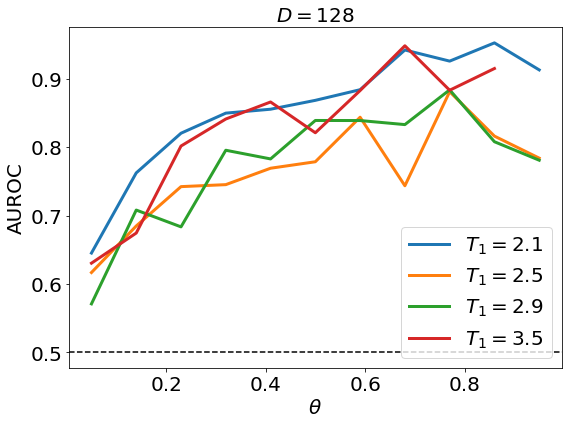

In [15]:
fig, ax = plt.subplots()

ax.set_title(r'$D=128$', fontsize=20)

for T1 in [2.1, 2.5, 2.9, 3.5]:
    ax.plot(
        auroc_df[T1][0], auroc_df[T1][1],
        ls='-', lw=3.0,
        label=f'$T_1={T1}$'
    )

ax.axhline(y=0.5, c='k', ls='--')
ax.set_xlabel(r'$\theta$', fontsize=20)
ax.set_ylabel('AUROC', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=20)

plt.show()